In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

### Load Data

In [4]:
data = pd.read_parquet("temp_data/prepared_data_normed.pq")
test_data = pd.read_parquet("temp_data/test_data_normed.pq")

In [5]:
# Set a seed for reproducibility (optional)
np.random.seed(42)

# Perform random sampling
sample_size = round(data.shape[0]*0.3)
random_sample = data.sample(n=sample_size)

random_sample

,enquiry_submit_count,agent_phone_count,add_to_cart_count,view_item_count,listing_engagement_count,days_active,weekend_ratio
158284,-0.120719,-0.022304,-0.109553,-0.476289,-0.648019,-0.014304,-0.692026
4039,-0.120719,-0.046262,-0.109553,-0.727198,0.555223,-0.348184,2.099040
45861,-0.120719,-0.046262,-0.109553,-0.580834,-0.045565,-0.431655,0.354624
92763,-0.120719,-0.046262,-0.109553,0.794988,-0.126059,-0.181244,-0.953688
256265,-0.120719,-0.046262,-0.109553,-0.727198,-0.652186,-0.348184,-0.517584
...,...,...,...,...,...,...,...
125785,-0.120719,-0.046262,-0.109553,-0.727198,-0.631770,-0.431655,0.354624
18631,-0.120719,-0.046262,-0.109553,1.175535,2.124271,-0.264714,-0.808320
156183,-0.120719,-0.046262,-0.109553,0.150986,0.660215,-0.348184,2.099040
73747,2.320886,-0.026137,3.409616,0.982335,1.735101,1.488157,-0.953688


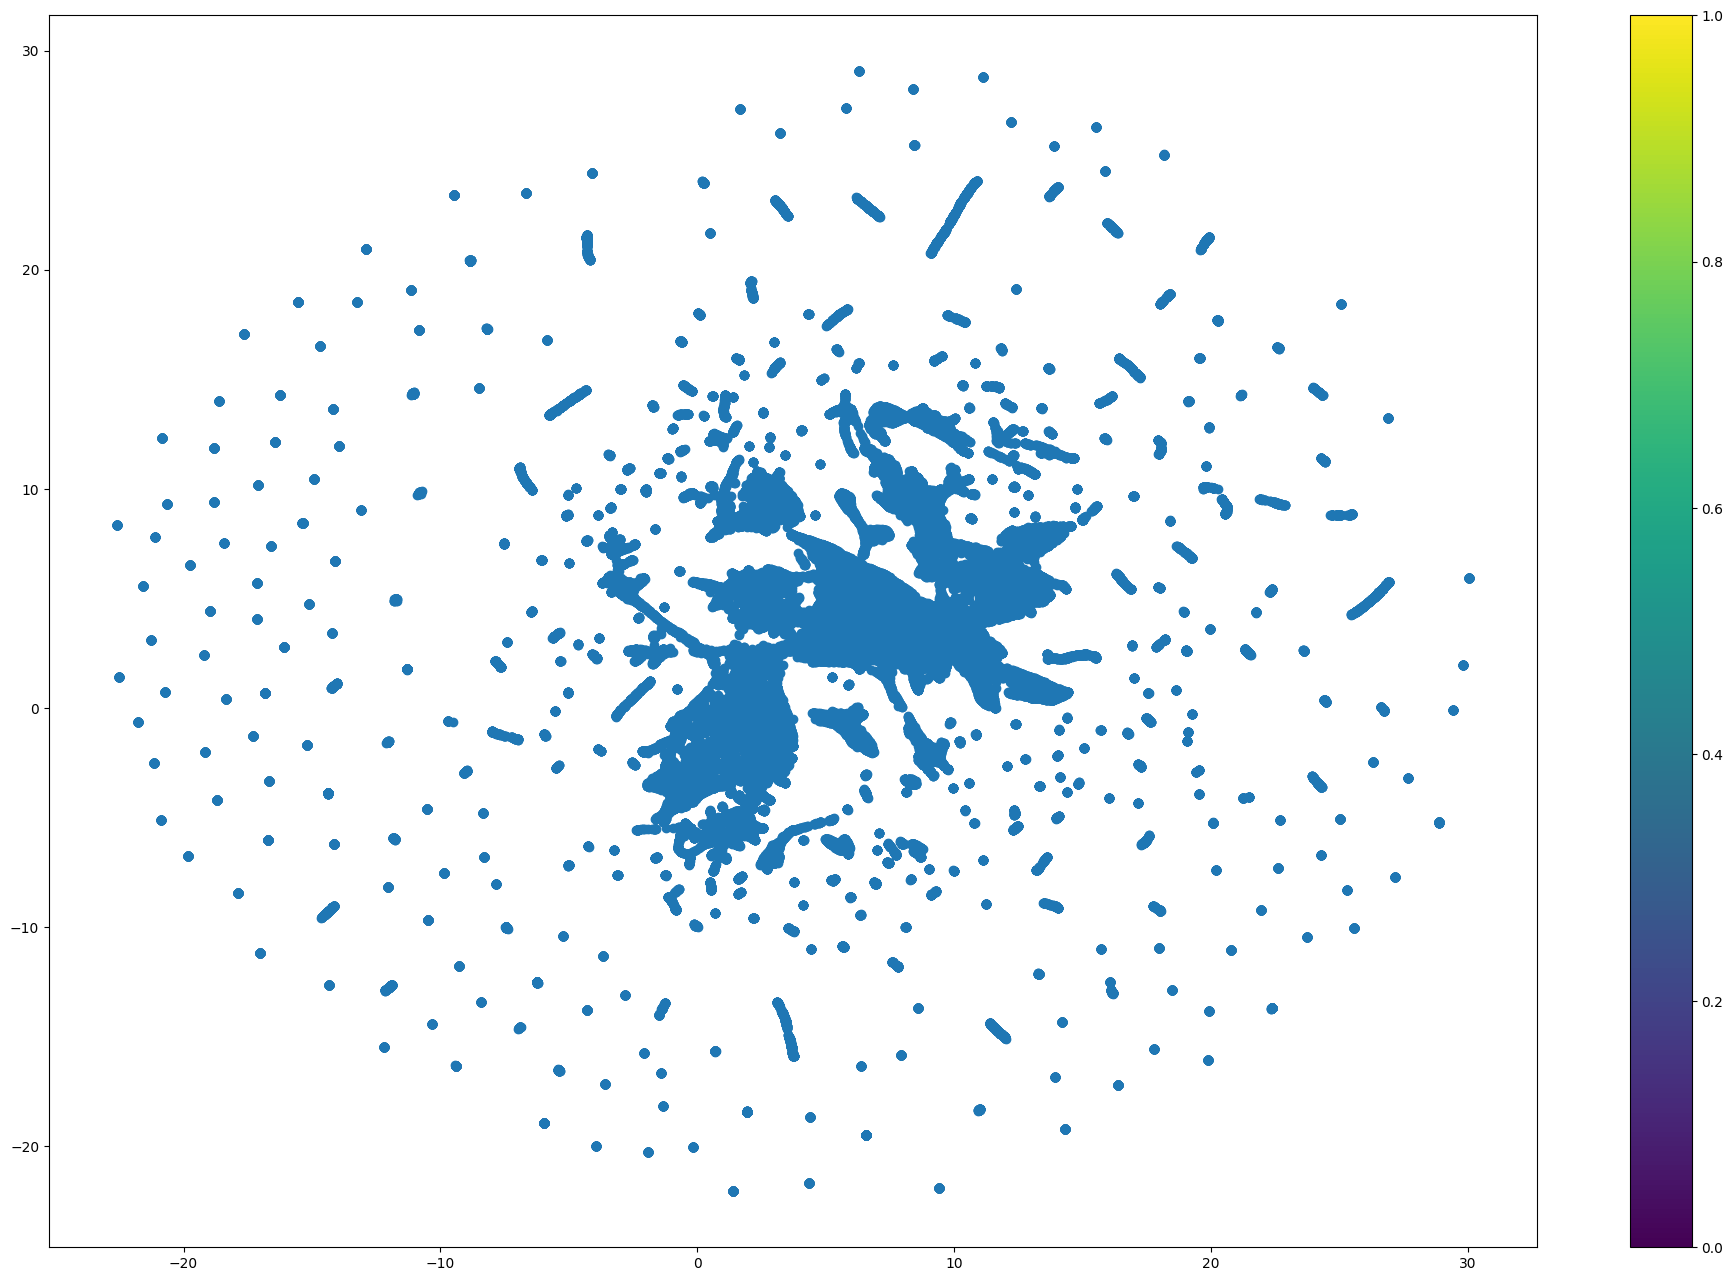

In [6]:
# to do so, we need to use UMAP
# It will give you a map to analyse
import umap.umap_ as umap

if "umap_model" in locals():
    del umap_model

# defining the UMAP model
umap_model = umap.UMAP(n_components=2, metric='euclidean', n_neighbors=30, min_dist=0.05, n_epochs=200, n_jobs=8)

# fitting
embedding = umap_model.fit_transform(random_sample)

plt.figure(figsize=(24,16))
plt.scatter(embedding[:, 0], embedding[:, 1])
# plt.title(f"Amount of clusters is {n_clusters}, batch size is {batch_size}")
plt.colorbar()
plt.show()

### Model run

After we had visualised the data, we can run the model

#### First step
is to see the scores to choose between the clusters.<br>
Consider the plot to be your help when comparing to the score results<br>
We want `calinski_harabasz score` to be higher<br>
and `davies_bouldin` to be lower

In [7]:
F = data.values

In [8]:

if "mbk_new" in locals():
    del mbk_new

for n_clusters in range(2, 15):
    print(f"running {n_clusters} number of clusters")
    mbk_new = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, n_init=10, batch_size=512)
    cluster_labels = mbk_new.fit_predict(F)
    # silhouette_avg = silhouette_score(F, cluster_labels)
    # print("For n_clusters = {}, the average silhouette score is {:.2f}".format(n_clusters, silhouette_avg))
    ch_score = calinski_harabasz_score(F, cluster_labels)
    db_score = davies_bouldin_score(F, cluster_labels)
    print("For n_clusters = {}, the average calinski_harabasz score is {:.2f}".format(n_clusters, ch_score))
    # the higher the better
    print("For n_clusters = {}, the average davies_bouldin score is {:.2f}".format(n_clusters, db_score))
    # the lower the better

running 2 number of clusters
For n_clusters = 2, the average calinski_harabasz score is 41287.55
For n_clusters = 2, the average davies_bouldin score is 1.54
running 3 number of clusters
For n_clusters = 3, the average calinski_harabasz score is 28337.16
For n_clusters = 3, the average davies_bouldin score is 1.64
running 4 number of clusters
For n_clusters = 4, the average calinski_harabasz score is 29064.61
For n_clusters = 4, the average davies_bouldin score is 1.62
running 5 number of clusters
For n_clusters = 5, the average calinski_harabasz score is 23973.66
For n_clusters = 5, the average davies_bouldin score is 1.68
running 6 number of clusters
For n_clusters = 6, the average calinski_harabasz score is 29479.88
For n_clusters = 6, the average davies_bouldin score is 1.17
running 7 number of clusters
For n_clusters = 7, the average calinski_harabasz score is 28939.78
For n_clusters = 7, the average davies_bouldin score is 1.53
running 8 number of clusters
For n_clusters = 8, the

#### Prepare the clusters
Now let's run the model with chosen parameters.

In [12]:
if "mbk" in locals():
    del mbk

# sample_df = user_embeddings_full.sample(frac=0.5, random_state=1)

n_clusters = 6
batch_size = 256

# random_state == seeding
mbk = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, n_init=10, batch_size=batch_size)
mbk.fit(F)
mbk_means_cluster_centers = np.sort(mbk.cluster_centers_, axis=0)
mbk_means_labels = pairwise_distances_argmin(F, mbk_means_cluster_centers)
yhat_6 = mbk.predict(F)

# plt.figure(figsize=(12,8))
# plt.scatter(embedding[:, 0], embedding[:, 1], c=yhat_7)
# plt.title(f"Amount of clusters is {n_clusters}, batch size is {batch_size}")
# plt.colorbar()
# plt.show()

In [13]:
full_df = pd.DataFrame(F, columns=data.columns)
full_df["cluster"] = yhat_6

In [14]:
# Set a seed for reproducibility (optional)
np.random.seed(42)

# Perform random sampling
sample_size = round(full_df.shape[0]*0.3)
fulll_random_sample = full_df.sample(n=sample_size)

#### Plotting
And let's add clusters as colours to the plot

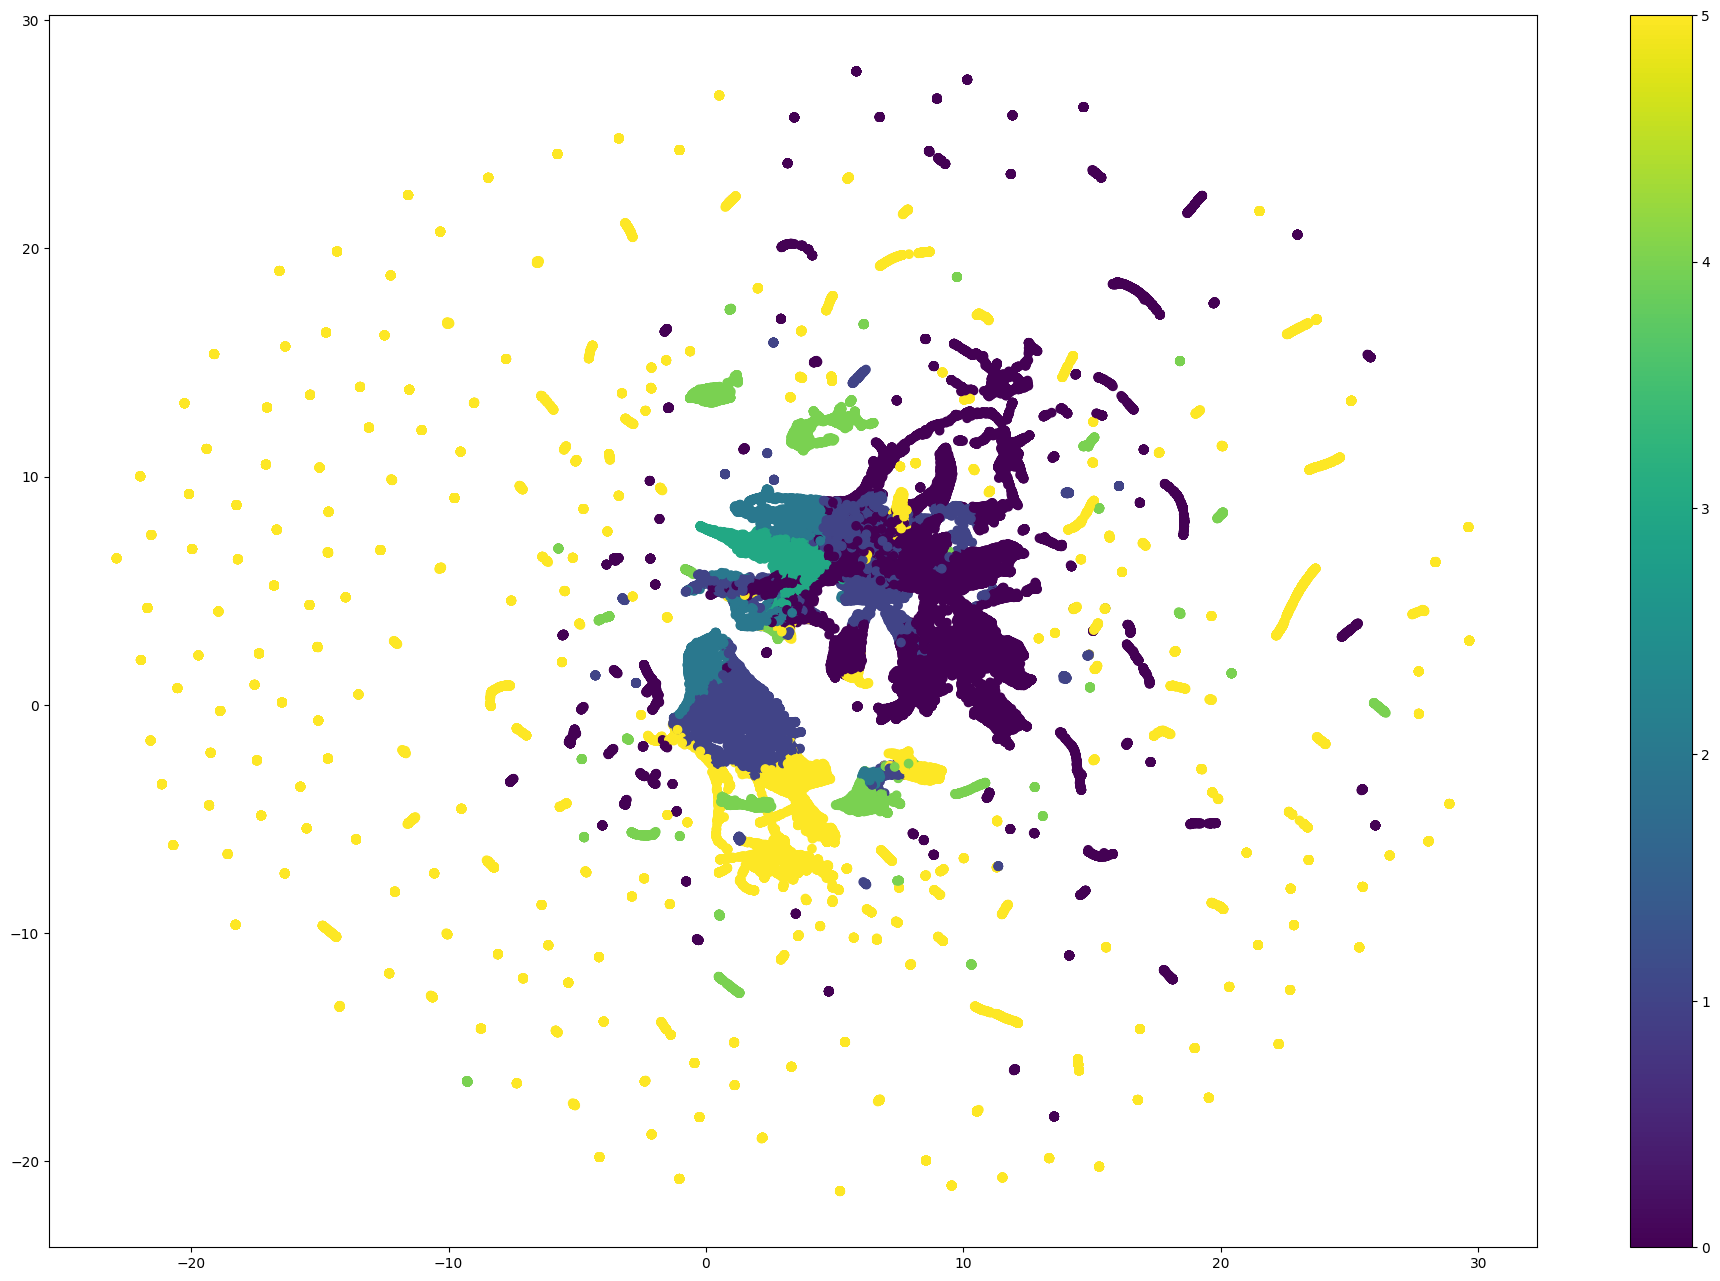

In [17]:
# to do so, we need to use UMAP
# It will give you a map to analyse
import umap.umap_ as umap

if "umap_model" in locals():
    del umap_model

# defining the UMAP model
umap_model = umap.UMAP(n_components=2, metric='euclidean', n_neighbors=30, min_dist=0.05, n_epochs=200, n_jobs=8)

# fitting
embedding = umap_model.fit_transform(fulll_random_sample.drop(columns="cluster"))

plt.figure(figsize=(24,16))
plt.scatter(embedding[:, 0], embedding[:, 1], c=fulll_random_sample.cluster)
# plt.title(f"Amount of clusters is {n_clusters}, batch size is {batch_size}")
plt.colorbar()
plt.show()

<br>
<br>
<br>
<br>

### Predict on Test data to see if the results would align.
When we have chosen the model and are satisfied with the result,<br>
we can run it on the test dataset.

In [18]:
test_yhat_6 = mbk.predict(test_data.values)

#### Save data with clusters
For the learning purposes I will move on with current clusters without further investigation<br>
<br>
We have changed the data to normalized it, but we have never shuffled it, so we can add clusters to initial dataset

In [19]:
X_train_prep = pd.read_parquet("temp_data/prepared_train_data.pq")
X_test_prep = pd.read_parquet("temp_data/prepared_test_data.pq")

X_train_prep["cluster"] = yhat_6
X_test_prep["cluster"] = test_yhat_6

X_train_prep.to_parquet("temp_data/clustered_data.pq")
X_test_prep.to_parquet("temp_data/clustered_test_data.pq")